<table>
 <tr align=left><td><img align=left src="./images/CC-BY.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli</td>
</table>

Note:  This material largely follows the text "Numerical Linear Algebra" by Trefethen and Bau (SIAM, 1997) and is meant as a guide and supplement to the material presented there.

In [1]:
%matplotlib inline
%precision 3
import numpy
import matplotlib.pyplot as plt

# Numerical Linear Algebra

Numerical methods for linear algebra problems lies at the heart of many numerical approaches and is something we will spend some time on.  Roughly we can break down problems that we would like to solve into three general problems, solving a system of equations

$$
A \mathbf{x} = \mathbf{b}
$$

Projection problems or Linear Least Squares

$$ A^TA\mathbf{x} = A^T\mathbf{b}$$

and solving the eigenvalue problem

$$A \mathbf{v} = \lambda \mathbf{v}.$$

We examine each of these problems separately and will evaluate some of the fundamental properties and methods for solving these problems. We will be careful in deciding how to evaluate the results of our calculations and try to gain some understanding of when and how they fail.

## Factorizations

For each fundamental problem, there are a range of algorithms to solve them, but all of these algorithms can often be succinctly described in terms of a matrix "factorization", the ability to write an arbitrary matrix $A$ as a product of matrices with special properties (e.g. triangular, diagonal, orthogonal) that make solving the general problem straightforward.  For example

<table width="80%">
    <tr align="left"><th>Problem</th> <th align="center">Algorithms</th> <th align="center">"Factorizations"</th></tr>
     <tr align="left"><td>$$A \mathbf{x} = \mathbf{b}$$</td> <td align="left">Gaussian-Elimination, Gauss-Jordan Elimination</td> <td align="center">$PA=LU$, $A=ER$</td></tr>
    <tr align="center"><td>$$ A^TA\mathbf{x} = A^T\mathbf{b}$$</td> <td align="center">Orthogonalization algorithms (Gram-Schmidt, Modified GS, Householder, Givens)</td> <td align="center">$A=QR$</td></tr>
    <tr align="center"><td>$$A \mathbf{v} = \lambda \mathbf{v}$$</td> <td align="center">Various Iterative methods (Power, inverse power, $RQ$ with shifts$\ldots$</td> <td align="center">$A=S\Lambda S^{-1}$, $A=Q\Lambda Q^T$, $A=MJM^{-1}$</td></tr>
    <tr align="center"><td align="left">All of the above</td> <td align="center">Singular Value Decomposition (SVD)</td> <td align="center">$A = U\Sigma V^T$</td></tr>
</table>

To develop all of these algorithms in depth is a course in itself, however, here we will highlight some of the key factorizations and algorithms used in modern computational linear algebra.  In particular we will highlight issues of accuracy, stability and computational cost particularly in the limit of large systems.

## Some Example Problems

The number and power of the different tools made available from the study of linear algebra makes it an invaluable field of study. Before we dive in to numerical approximations we first consider some of the pivotal problems that numerical methods for linear algebra are used to address.

For this discussion we will be using the common notation $m \times n$ to denote the dimensions of a matrix $A$.  The $m$ refers to the number of rows and $n$ the number of columns.  If a matrix is square, i.e. $m = n$, then we will use the notation that $A$ is $m \times m$.

### Systems of Equations

The first type of problem is to find the solution to a linear system of equations.  If we have $m$ equations for $m$ unknowns it can be written in matrix/vector form,

$$A \mathbf{x} = \mathbf{b}.$$

For this example $A$ is an $m \times m$ matrix, denoted as being in $\mathbb{R}^{m\times m}$, and $\mathbf{x}$ and $\mathbf{b}$ are column vectors with $m$ entries, denoted as $\mathbb{R}^m$.

#### Example 1:  Polynomial Fitting
In our previous work on interpolation we found that the unique interpolating polynomial of order $n$ through the $n+1$ points $(x_i, y_i)$ can be found by solving a Linear system of equations 

$$
V[\phi_j(\mathbf{x})]\mathbf{w} = \mathbf{y}
$$

where $V$ is a VanderMonde matrix whose columns are the basis functions $\phi_j(\mathbf{x})$ (e.g. the monomials) and $\mathbf{w}\in\mathbb{R}^{n+1}$ are the coefficients (weights) such that the interpolating polynomial is given uniquely by
$$
    \cal{P}_n(x) = \sum_{j=0}^n w_j\phi_j(x)
$$

#### Examples 2: Solution of Non-linear equations by Newton's Method

Given a non-linear system of equations 

$$\mathbf{F}(\mathbf{x})=\mathbf{0}$$

Newton's method provides an iterative method to find roots where at every step of the iteration a linear system of equations

$$
    J(\mathbf{x_k})\boldsymbol{\delta}_k = -\mathbf{F}(\mathbf{x_k})
$$

#### Examples 3: Solution of Boundary Value problems by Finite Differences or Finite Elements

Given a general linear differential equation

$${\cal L}u = f$$

where ${\cal L}$ is a linear differential operator e.g.

$$
    {\cal L} = \frac{d^2}{dx^2} + \alpha\frac{d}{dx} + \beta
$$

Finite difference or finite element discretizations usually reduce the continuous, infinite dimensional problem to a discrete linear problem of form

$$
    A\mathbf{u} = \mathbf{f}
$$

Where $\mathbf{u}$ and $\mathbf{f}$ are discrete approximations to the solution function and right hand side and $A$ is a discrete approximation to ${\cal L}$.  Moreover, for many discretizations, $A$ can be very sparse.

### Linear least squares

In a similar case as above, say we want to fit a particular function (could be a polynomial) to a given number of data points except in this case we have more data points than free parameters.  In the case of polynomials this could be the same as saying we have $m$ data points but only want to fit a $n - 1$ order polynomial through the data where $n - 1 \leq m$.  One of the common approaches to this problem is to minimize the "least-squares" error between the data and the resulting function:
$$
    E = \left( \sum^m_{i=1} |y_i - f(x_i)|^2 \right )^{1/2}.
$$

E.g. Consider fitting the function 
$$
    f(x) = w_1 + w_2 x + w_3 e^x
$$ 

to data that has random noise added to it.

If our function $f(x)$ can be written as a linear combination of basis functions

$$
    f(x) = \sum_{j=1}^n w_j\phi_j(x)
$$

then the linear system through $m$ points becomes $A\mathbf{w} = \mathbf{y}$ where $A$ is a generalized $m\times n$ vandermonde matrix

$$
    A = \begin{bmatrix}
        \phi_1(x_1) & \phi_2(x_1) & \cdots & \phi_n(x_1) \\
        \phi_1(x_2) & \phi_2(x_2) & \cdots &  \phi_n(x_2) \\
        \vdots & \vdots & &\vdots   \\
        \phi_1(x_m) & \phi_2(x_m) & \cdots &  \phi_n(x_m) \\
    \end{bmatrix}
$$

Which will be over-determined for $m > n$.  However the Least-squares solution for the weights $\mathbf{w}$ will satisfy

$$A^T A \mathbf{w} = A^T \mathbf{y}$$

we can guarantee that the error is minimized in the least-squares sense[<sup>1</sup>](#footnoteRegression). (Although we will also show that this is not the most numerically stable way to solve this problem)



#### Define the data

In [2]:
N = 20
x = numpy.linspace(-1.0, 1.0, N)
y = x + numpy.random.random((N)) 

#### Define basis functions and Vandermonde matrix

In [3]:
# define the basis functions
phi_1 = lambda x: numpy.ones(x.shape)
phi_2 = lambda x: x
phi_3 = lambda x: numpy.exp(x)
# Define various Vandermonde matrix based on our x-values
A = numpy.array([ phi_1(x), phi_2(x), phi_3(x)]).T
A.shape

(20, 3)

In [4]:
# Determine the weights of our linear function
# result in the smallest sum of the squares of the residual.
w = numpy.linalg.solve(numpy.dot(A.T, A), numpy.dot(A.T, y))
error = y - A.dot(w)
print('w = {}, ||e|| = {}'.format(w,numpy.linalg.norm(error)))

w = [ 1.025  1.611 -0.485], ||e|| = 1.338766805774944


In [5]:
# Do the same using numpy's lstsq routine (which solves a more numerically stable problem)
w = numpy.linalg.lstsq(A,y, rcond=None)[0]
error = y - A.dot(w)
print('w = {}, ||e|| = {}'.format(w,numpy.linalg.norm(error)))

w = [ 1.025  1.611 -0.485], ||e|| = 1.3387668057749436


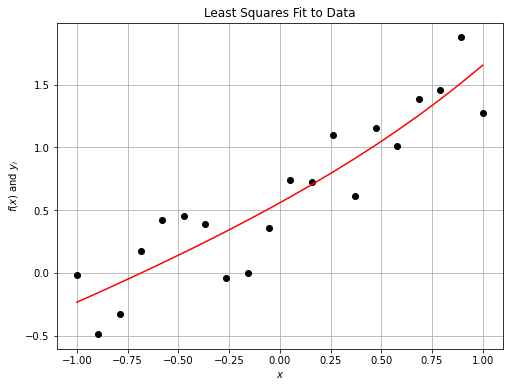

In [6]:
# just repeat the calculations to draw the figure
# define data
N = 20
x = numpy.linspace(-1.0, 1.0, N)
y = x + numpy.random.random((N)) 

# define the basis functions
phi_1 = lambda x: numpy.ones(x.shape)
phi_2 = lambda x: x
phi_3 = lambda x: numpy.exp(x)
# Define various Vandermonde matrix based on our x-values
A = numpy.array([ phi_1(x), phi_2(x), phi_3(x)]).T
w = numpy.linalg.lstsq(A,y, rcond=None)[0]


# Plot it out, cuz pictures are fun!
fig = plt.figure(figsize=(8,6))
axes = fig.add_subplot(1, 1, 1)
f = A.dot(w)
axes.plot(x, y, 'ko')
axes.plot(x, f, 'r')
axes.set_title("Least Squares Fit to Data")
axes.set_xlabel("$x$")
axes.set_ylabel("$f(x)$ and $y_i$")
axes.grid()

plt.show()

### Eigenproblems

Eigenproblems come up in a variety of contexts and often are integral to many problem of scientific and engineering interest. It is such a powerful idea that it is not uncommon for us to take a problem and convert it into an eigenproblem. 

One of my favorite examples [The Tacoma Narrows Bridge Collapse](https://www.youtube.com/watch?v=XggxeuFDaDU)

Or the original Google [Page-Rank](https://en.wikipedia.org/wiki/PageRank) algorithm which essentially finds the dominant eigenvector of an enormous sparse Markov Matrix.

Here we introduce the idea and give some examples.

As a review, if $A \in \mathbb{C}^{m\times m}$ (a square matrix with complex values), a non-zero vector $\mathbf{v}\in\mathbb{C}^m$ is an **eigenvector** of $A$ with a corresponding **eigenvalue** $\lambda \in \mathbb{C}$ if 

$$A \mathbf{v} = \lambda \mathbf{v}.$$

One way to interpret the eigenproblem is that we are attempting to ascertain the "action" of the matrix $A$ on some subspace of $\mathbb{C}^m$ where this action acts like scalar multiplication.  This subspace is called an **eigenspace**.

#### General idea of EigenProblems

Rewriting the standard Eigen problem $A\mathbf{v}=\lambda\mathbf{v}$ for $A \in \mathbb{C}^{m\times m}$, $\mathbf{v}\in\mathbb{C}^m$ as

$$
    (A - \lambda I)\mathbf{v} = \mathbf{0}
$$ 

it becomes clear that for $\mathbf{v}$ to be non-trivial (i.e. $\neq \mathbf{0}$), requires that the matrix $(A-\lambda I)$ be singular,  

This is equivalent to finding all values of $\lambda$ such that $|A-\lambda I| = 0$ (the determinant of singular matrices is always zero).  However, it can also be shown that 

$$
   | A-\lambda I| = P_m(\lambda)
$$

which is a $m$th order polynomial in $\lambda$.  Thus $P_m(\lambda)=0$ implies the eigenvalues are the $m$ roots of $P$, and the **eigenspace** corresponding to $\lambda_i$ is just $N(A-\lambda_i I)$


#### Solving EigenProblems

The temptation (and what we usually teach in introductory linear algebra classes) is to find the roots of $P_m(\lambda)$  to get the eigenvalues, then find the null-space of $A-\lambda I$. 

However that would be **wrong**.  The best algorithms for finding Eigenvalues are completely unrelated to rootfinding as we shall see (and in fact, the way you find the roots of polynomials is to find the eigenvalues of a "companion matrix")

### The Singular Value Decomposition

One of the most beautiful, and useful, factorizations is the Singular Value Decomposition (or SVD),  

$$
    A = U\Sigma V^T
$$

where $A$ is a general $m\times n$ matrix, $U$ and $V$ are unitary (orthogonal) matrices such that $U^TU=I^{m\times m}$, $V^TV = I^{n\times n}$ and $\Sigma$ is a diagonal matrix with real, positive  diagonal entries (the singular values)

$$
    \sigma_1 \geq \sigma_2\geq \ldots \sigma_{r} > 0
$$
where $r$ is the rank of $A$

#### Applications of the SVD

The SVD combines all the aspects of basic linear algebra and is used in a large number of applications including

* diagnosing ill-conditioned matrices
* providing orthonormal bases for the 4-subspaces of $A$
* Solving linear systems and linear least-squares problems
* Solving ill-conditioned and singular linear systems (Pseudo-inverse)
* Dimensional reduction in Data analysis (PCA, EOF, POD analysis)
* and more...

Because of its ubiquity in computational linear algebra and data science. we will spend a bit of time to understand the SVD and its applications (but not the specific algorithms).  But first

## Fundamentals

**Objectives**
* Understand basic linear-algebraic operations and their **computational costs**
* Understand Numpy implementation (and performance) for Linear Algebra
* Understand Singular vs Invertible matrices
* Understand Orthonormal vectors and $Q$ matrices
* Understand vector and Matrix norms
* Understand the **Condition Number**

### Matrix-Vector Multiplication 

One of the most basic operations we can perform with matrices is to multiply them by a vector which maps a vector to a vector.  There are multiple ways to interpret and compute the matrix-vector product $A \mathbf{x}$.

#### index notation
$$
    b_i = \sum^n_{j=1} a_{ij} x_j \quad \text{where}\quad i = 1, \ldots, m
$$

#### row picture (dot products)
We can also consider matrix-vector multiplication as a sequence of inner products (dot-products between the rows of $A$ and the vector $\mathbf{x}$.  
\begin{align}
    \mathbf{b} &= A \mathbf{x}, \\
     &= 
    \begin{bmatrix}  \mathbf{a}_1^T \mathbf{x} \\ \mathbf{a}_2^T \mathbf{x} \\ \vdots \\ \mathbf{a}_m^T \mathbf{x}\end{bmatrix}
\end{align}
where $\mathbf{a}_i^T$ is the $i$th **row** of $A$

#### column picture

An alternative (and entirely equivalent way) to write the matrix-vector product is as a linear combination of the columns of $A$ where each column's weighting is $x_j$.

$$
\begin{align}
    \mathbf{b} &= A \mathbf{x}, \\
    &= 
    \begin{bmatrix}  &  &  &  \\  &  &  &  \\ \mathbf{a}_1 & \mathbf{a}_2 & \cdots & \mathbf{a}_n \\  &  &  &   \\  &  &  &  \end{bmatrix}
    \begin{bmatrix} x_1 \\ x_2 \\ \vdots \\ x_n \end{bmatrix}, \\
  &= x_1 \mathbf{a}_1 + x_2 \mathbf{a}_2 + \cdots + x_n \mathbf{a}_n.
\end{align}
$$

This view will be useful later when we are trying to interpret various types of matrices.

### Operation Counts
No matter how you compute $A\mathbf{x}$,  the total number of operations is the same (for a dense matrix $A$). 
The row view however is convenient for calculating the **Operation counts** required for $A\mathbf{x}$.  

If $A\in\mathbb{C}^{m\times n}$ and $\mathbf{x}\in\mathbb{C}^n$.  Then just counting the number of multiplications involved to compute $A\mathbf{x}$ is $O(??)$


One important property of the matrix-vector product is that is a **linear** operation, also known as a **linear operator**.  This means that the for any $\mathbf{x}, \mathbf{y} \in \mathbb{C}^n$ and any $c \in \mathbb{C}$ we know that

1. $A (\mathbf{x} + \mathbf{y}) = A\mathbf{x} + A\mathbf{y}$
1. $A\cdot (c\mathbf{x}) = c A \mathbf{x}$

#### Example:  Numerical matrix-vector multiply

Write a matrix-vector multiply function and check it with the appropriate `numpy` routine.  Also verify the linearity of the matrix-vector multiply.

In [7]:
# Mat-vec in index notation (the long way...don't do this)
def matrix_vector_product_index(A, x):
    m, n = A.shape
    b = numpy.zeros(m)
    for i in range(m):
        for j in range(n):
            b[i] += A[i, j] * x[j]
    return b

# Mat-vec by row picture (still don't do this)
def matrix_vector_product_row(A, x):
    m, n = A.shape
    b = numpy.zeros(m)
    # loop on rows
    for i in range(m):
        b[i] = A[i, :].dot(x)
    return b

# Mat-vec by column picture (still don't do this)
def matrix_vector_product_col(A, x):
    m, n = A.shape
    b = numpy.zeros(m)
    # loop over columns
    for j in range(n):
            b += A[:, j] * x[j]
    return b


#### Check equivalence

first set up some large random matrices and vectors and compare to numpy built in .dot function

In [8]:
m = 1000
n = 1000
A = numpy.random.uniform(size=(m,n))
x = numpy.random.uniform(size=(n))
y = numpy.random.uniform(size=(n))
c = numpy.random.uniform()

In [9]:
funcs = [ matrix_vector_product_index,  matrix_vector_product_row,  matrix_vector_product_col ] 
for f in funcs:
    b = f(A, x)
    print('{}(A,x) = A.dot(x)? {}'.format(f.__name__, numpy.allclose(b,  )

SyntaxError: unexpected EOF while parsing (<ipython-input-9-e797815c7881>, line 4)

#### Check Linearity

In [ ]:
for f in funcs:
    print('{}(A,x+y) = Ax + Ay is {}'.format(f.__name__, 
                                         numpy.allclose(f(A, (x + y)), f(A, x) + f(A, y))))
    print('{}(A,cx) = cAx  is {}\n'.format(f.__name__, 
                                         numpy.allclose(f(A, c * x), c*f(A, x))))
    

#### Check Timing/performance

In [ ]:
for f in funcs:
    print(f.__name__,end='\t')
    %timeit f(A,x)

print('numpy.dot(A,x)',end='\t\t\t')
%timeit A.dot(x)

### Matrix-Matrix Multiplication

The matrix product with another matrix $ C=AB$ is defined as
$$
    c_{ij} = \sum^m_{k=1} a_{ik} b_{kj} = \mathbf{a}_i^T\mathbf{b}_j
$$

i.e. each component of $C$ is a dot-product between the $i$th row of $A$ and the $j$th column of $B$

As with matrix-vector multiplication, Matrix-matrix multiplication can be thought of multiple ways

* $m\times p$ dot products (each with $n$ flops)
* $A$ multiplying the columns of $B$
$$
    C = AB = \begin{bmatrix} 
                A\mathbf{b}_1 & A\mathbf{b}_2 & \ldots & A\mathbf{b}_p\\ 
             \end{bmatrix}
$$
* Linear combinations of the rows of $B$
$$
C = AB = \begin{bmatrix} 
                \mathbf{a}_1^T B \\ \mathbf{a}_2^T B \\ \vdots \\ \mathbf{a}_m^T B\\ 
             \end{bmatrix}
$$

### Questions
* What are the dimensions of $A$ and $B$ so that the multiplication works?
* What are the Operations Counts for Matrix-Matrix Multiplication?
* Comment on the product $\mathbf{c}=(AB)\mathbf{x}$ vs. $\mathbf{d} = A(B\mathbf{x})$

#### Example:  Outer Product

The product of two vectors $\mathbf{u} \in \mathbb{C}^m$ and $\mathbf{v} \in \mathbb{C}^n$ is a $m \times n$ matrix where the columns are the vector $u$ multiplied by the corresponding value of $v$:
$$
\begin{align}
    \mathbf{u} \mathbf{v}^T &= 
    \begin{bmatrix}  u_1 \\ u_2 \\ \vdots \\ u_m  \end{bmatrix}
    \begin{bmatrix} v_1 & v_2 & \cdots & v_n \end{bmatrix}, \\
    & = \begin{bmatrix} v_1u_1 & \cdots & v_n u_1 \\ \vdots &  & \vdots \\ v_1 u_m & \cdots & v_n u_m \end{bmatrix}.
\end{align}
$$

It is useful to think of these as operations on the column vectors, and an equivalent way to express this relationship is 
$$
\begin{align}
    \mathbf{u} \mathbf{v}^T &=
    \begin{bmatrix}  \\ \mathbf{u} \\ \\  \end{bmatrix}
    \begin{bmatrix} v_1 & v_2 & \cdots & v_n \end{bmatrix}, \\
    &=
    \begin{bmatrix}  &  &  &  \\  &  &  &  \\ \mathbf{u}v_1  & \mathbf{u} v_2  & \cdots & \mathbf{u} v_n  \\  &  &  & \\  &  &  &  \end{bmatrix}, \\
    & = \begin{bmatrix} v_1u_1 & \cdots & v_n u_1 \\ \vdots &  & \vdots \\ v_1 u_m & \cdots & v_n u_m \end{bmatrix}.
\end{align}
$$

Or each column is just a scalar multiple of $\mathbf{u}$

Alternatively you can think of this as the rows are all just scalar multiples of $\mathbf{v}$

### rank 1 updates

We call any matrix of the form $\mathbf{u}\mathbf{v}^T$ a "rank one matrix"  ( because its rank r=?).  These sort of matrix operations are very common in numerical algorithms for orthogonalization, eigenvalues and the original page-rank algorithm for google.  Again, the order of operations is critical.

Comment on the difference in values and operation counts between

$$
    \mathbf{y} = (\mathbf{u}\mathbf{v}^T)\mathbf{x}
$$

and 
$$
    \tilde{\mathbf{y}} = \mathbf{u}(\mathbf{v}^T\mathbf{x})
$$
for $\mathbf{u}$, $\mathbf{v}$, $\mathbf{x}$, $\mathbf{y}$, $\tilde{\mathbf{y}}\in\mathbb{R}^n$, 

### Check 

Set up some random vectors

In [ ]:
m = 10000
n = 10000
u = numpy.random.rand(m)
v = numpy.random.rand(n)
x = numpy.random.rand(n)

#### Check Equivalence of numbers 

show 
$$
    (\mathbf{u}\mathbf{v}^T)\mathbf{x} = \mathbf{u}(\mathbf{v}^T\mathbf{x})
$$

In [ ]:
b = numpy.outer(u,v).dot(x)
c = u.dot(v.dot(x))
d = u*v.dot(x)
print('Max Difference = {}'.format(numpy.max(numpy.abs(b-c))))
print('Max Difference = {}'.format(numpy.max(numpy.abs(b-d))))
print('Max Difference = {}'.format(numpy.max(numpy.abs(c-d))))

#### Check Timing/performance

In [ ]:
# timing
print('(uv^T).dot(x)',end='\t\t')
%timeit numpy.outer(u,v).dot(x)
print('\nu*v.dot(x)',end='\t\t')
%timeit u*v.dot(x)

#### Example:  Upper Triangular Multiplication

Consider the multiplication of a matrix $A \in \mathbb{C}^{m\times n}$ and the **upper-triangular** matrix $R$ defined as the $n \times n$ matrix with entries $r_{ij} = 1$ for $i \leq j$ and $r_{ij} = 0$ for $i > j$.  The product can be written as
$$
    \begin{bmatrix}  \\  \\ \mathbf{b}_1 & \cdots & \mathbf{b}_n \\ \\ \\ \end{bmatrix} = \begin{bmatrix} \\ \\  \mathbf{a}_1 & \cdots & \mathbf{a}_n \\ \\ \\ \end{bmatrix} \begin{bmatrix} 1 & \cdots & 1 \\  & \ddots & \vdots \\  &  & 1 \end{bmatrix}.
$$

The columns of $B$ are then
$$
    \mathbf{b}_j = A \mathbf{r}_j = \sum^j_{k=1} \mathbf{a}_k
$$
so that $\mathbf{b}_j$ is the sum of the first $j$ columns of $A$.

#### Example: Write Matrix-Matrix Multiplication

Write a function that computes matrix-matrix multiplication and demonstrate the following properties:
1. $A (B + C) = AB + AC$ (for square matrices))
1. $A (cB) = c AB$ where $c \in \mathbb{C}$
1. $AB \neq BA$ in general

In [ ]:
def matrix_matrix_product(A, B):
    C = numpy.zeros((A.shape[0], B.shape[1]))
    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            for k in range(A.shape[1]):
                C[i, j] += A[i, k] * B[k, j]
    return C


m = 4
n = 4
p = 4
A = numpy.random.uniform(size=(m, n))
B = numpy.random.uniform(size=(n, p))
C = numpy.random.uniform(size=(m, p))
c = numpy.random.uniform()
print(numpy.allclose(matrix_matrix_product(A, B), numpy.dot(A, B)))
print(numpy.allclose(matrix_matrix_product(A, (B + C)), matrix_matrix_product(A, B) + matrix_matrix_product(A, C)))
print(numpy.allclose(matrix_matrix_product(A, c * B), c*matrix_matrix_product(A, B)))
print(numpy.allclose(matrix_matrix_product(A, B), matrix_matrix_product(B, A)))

#### NumPy Products

NumPy and SciPy contain routines that are optimized to perform matrix-vector and matrix-matrix multiplication.  Given two `ndarray`s you can take their product by using the `dot` function.

In [ ]:
n = 10
# Matrix vector with identity
I = numpy.identity(n)
x = numpy.random.random(n)
print(x)

In [ ]:
print('x = Ix is {}\n'.format(numpy.allclose(x, numpy.dot(I, x))))

In [ ]:
print('x - I.dot(x) = {}\n'.format(x-I.dot(x)))

In [ ]:
print('I*x = \n{}\n'.format(I*x))

In [ ]:
print(I.dot(x))

In [ ]:
# Matrix vector product
m = 5
A = numpy.random.random((m, n))
print(numpy.dot(A, x))

In [ ]:
# Matrix matrix product
B = numpy.random.random((n, m))
print(numpy.dot(A, B))
print()
print(A.dot(B))

#### Check non-commutative property of matrix-matrix multiplication

It's easy to demonstrate the non-commutative nature of Matrix-Matrix multiplication with *almost* any two matrices $A$ and $B$.  For a clear demonstration,  consider the two matrices $D$ a diagonal matrix and $A$ a matrix of all 1s

In [ ]:
N=5
D = numpy.diag(numpy.array(range(1,N+1)))
A = numpy.ones((N,N))
print(D,'\n')
print(A)

In [ ]:
print(D.dot(A))

In [ ]:
print(A.dot(D))

### Range and Null-Space

#### Range
- The **range** of a matrix $A \in \mathbb R^{m \times n}$ (similar to any function), denoted as $\text{range}(A)$, is the set of vectors that can be expressed as $A x$ for $x \in \mathbb R^n$.  
- We can also then say that that $\text{range}(A)$ is the space **spanned** by the columns of $A$.  In other words the **linearly independent** columns of $A$ provide a basis for $\text{range}(A)$, also called the **column space** of the matrix $A$.  
- $C(A)$ controls the **existence** of solutions to $A\mathbf{x}=\mathbf{b}$

#### Null-Space
- Similarly the **null-space** of a matrix $A$, denoted $\text{null}(A)$ is the set of vectors $\mathbf{x}$ that satisfy $A \mathbf{x} = \mathbf{0}$.
- $N(A)$ controls the **uniqueness** of solutions to $A\mathbf{x}=\mathbf{b}$
- A similar concept is the **rank** of the matrix $A$, denoted as $\text{rank}(A)$, is the dimension of the column space.  A matrix $A$ is said to have **full-rank** if $\text{rank}(A) = \min(m, n)$.  This property also implies that the matrix mapping is **one-to-one**.

### Inverse

A **non-singular** or **invertible** matrix is characterized as a square matrix with full-rank.  This is related to why we know that the matrix is one-to-one, we can use it to transform a vector $x$ and using the inverse, denoted $A^{-1}$, we can map it back to the original matrix.  The familiar definition of this is
\begin{align*}
    A \mathbf{x} &= \mathbf{b}, \\
    A^{-1} A \mathbf{x} & = A^{-1} \mathbf{b}, \\
    x &=A^{-1} \mathbf{b}.
\end{align*}
Since $A$ has full rank, its columns form a basis for $\mathbb{R}^m$ and the vector $\mathbf{b}$ must be in the column space of $A$.

There are a number of important properties of an invertible matrix $A$.  Here we list them as the following equivalent statements
1. $A$ has a *unique* inverse $A^{-1}$ such that  $A^{-1}A=AA^{-1}=I$
1. $\text{rank}(A) = m$
1. $\text{range}(A) = \mathbb{C}^m$
1. $\text{null}(A) = \mathbf{0}$
1. 0 is not an eigenvalue of $A$
1. $\text{det}(A) \neq 0$

#### Example:  Properties of invertible matrices

Show that given an invertible matrix that the rest of the properties hold.  Make sure to search the `numpy` packages for relevant functions.

In [ ]:
m = 5
# generate a random m x m invertible matrix
for n in range(100):
    A = numpy.random.uniform(size=(m, m))
    if numpy.linalg.det(A) != 0:
        break
        
print('A^{{-1}}*A = \n\n{}\n'.format(numpy.dot(numpy.linalg.inv(A), A)))
print('rank(A) = {}\n'.format(numpy.linalg.matrix_rank(A)))
print("N(A)= {}\n".format(numpy.linalg.solve(A, numpy.zeros(m))))
print("Eigenvalues = {}".format(numpy.linalg.eigvals(A)))

### Orthogonal Vectors and Matrices

Orthogonality is a very important concept in linear algebra that forms the basis of many of the modern methods used in numerical computations.  

Two vectors are said to be *orthogonal* if their **inner-product** or **dot-product** defined as
$$
    < \mathbf{x}, \mathbf{y} > \equiv (\mathbf{x}, \mathbf{y}) \equiv \mathbf{x}^T\mathbf{y} \equiv \mathbf{x} \cdot \mathbf{y} = \sum^m_{i=1} x_i y_i = 0
$$
Here we have shown the various notations you may run into (the inner-product is in-fact a general term for a similar operation for mathematical objects such as functions).  

If $\langle \mathbf{x},\mathbf{y} \rangle = 0$ then we say $\mathbf{x}$ and $\mathbf{y}$ are orthogonal.  The reason we use this terminology is that the inner-product of two vectors can also be written in terms of the angle between them where

$$
    \cos \theta = \frac{\langle \mathbf{x}, \mathbf{y} \rangle}{||\mathbf{x}||_2~||\mathbf{y}||_2}
$$

and $||\mathbf{x}||_2$ is the Euclidean ($\ell^2$) norm of the vector $\mathbf{x}$, which we can interpret as the *length* of a vector.

We can write the 2-norm or length of a vector  in terms of the inner-product as well as
$$
    ||\mathbf{x}||_2^2 = \langle \mathbf{x}, \mathbf{x} \rangle = \mathbf{x}^T\mathbf{x} = \sum^m_{i=1} |x_i|^2.
$$

$$
    ||\mathbf{x}||_2 = \sqrt{\langle \mathbf{x}, \mathbf{x} \rangle}
$$

The generalization of the inner-product to complex vector spaces is defined as
$$
    \langle x, y \rangle = \sum^m_{i=1} x_i^* y_i
$$
where $x_i^*$ is the complex-conjugate of the value $x_i$.

#### Orthonormality

Taking this idea one step further we can say a set of vectors $\mathbf{x} \in X$ are orthogonal to $\mathbf{y} \in Y$ if 

$$
< \mathbf{x}, \mathbf{y} > = 0 \quad \forall \mathbf{x},\mathbf{y},  
$$ 

If in addition
$$||\mathbf{x}|| = 1,\, ||\mathbf{y}|| = 1\quad \forall \mathbf{x},\mathbf{y}
$$ 

then they are also called orthonormal. 

Note that we dropped the 2 as a subscript to the notation for the norm of a vector. Later we will explore other ways to define a norm of a vector other than the Euclidean norm defined above.

Another concept that is related to orthogonality is linear-independence.  A set of vectors $\mathbf{x} \in X$ are **linearly independent** if $\forall \mathbf{x} \in X$ that each $\mathbf{x}$ cannot be written as a linear combination of the other vectors in the set $X$. 



An equivalent statement is that given a set of $n$ vectors $\mathbf{x}_i$,  the only  set of scalars $c_i$ that satisfies
$$
    \sum_{i=1}^n c_i\mathbf{x}_i = \mathbf{0}
$$
is if $c_i=0$ for all $i\in[1,n]$


Show that if a set of vectors are orthonormal,  they must be linearly independent.

This can be related directly through the idea of projection.  If we have a set of vectors $\mathbf{x} \in X$ we can project another vector $\mathbf{v}$ onto the vectors in $X$ by using the inner-product.  This is especially powerful if we have a set of **orthogonal** vectors $X$, which are said to **span** a space (or provide a **basis** for a space), s.t. any vector in the space spanned by $X$ can be expressed as a linear combination of the basis vectors $X$
$$
    \mathbf{v} = \sum^n_{i=1} \, \langle \mathbf{v}, \mathbf{x}_i \rangle \, \mathbf{x}_i.
$$
Note if $\mathbf{v} \in X$ that 
$$
    \langle \mathbf{v}, \mathbf{x}_i \rangle = 0 \quad \forall \mathbf{x}_i \in X \setminus \mathbf{v}.
$$

Looping back to matrices, the column space of a matrix is spanned by its linearly independent columns.  Any vector $v$ in the column space can therefore be expressed via the equation above.  

### Unitary Matrices

A special class of matrices are called **unitary** matrices when complex-valued and **orthogonal** when purely real-valued if the columns of the matrix are *orthonormal* to each other.  Importantly this implies that for a unitary matrix $Q$ we know the following

1. $Q^*Q = I$
1. therefore if $Q$ is square, $Q^* = Q^{-1}$

where $Q^*$ is called the **adjoint** (or Hermitian) of $Q$.  The adjoint is defined as the transpose of the original matrix with the entries being the complex conjugate of each entry as the notation implies.  Note, if $Q\in\mathbb{R}^{n\times n}$ then $Q^*=Q^T$

As an example if we have the matrix
$$
\begin{aligned}
    Q &= \begin{bmatrix} q_{11} & q_{12} \\ q_{21} & q_{22} \\ q_{31} & q_{32} \end{bmatrix} \quad \text{then} \\
    Q^* &= \begin{bmatrix} q^*_{11} & q^*_{21} & q^*_{31} \\ q^*_{12} & q^*_{22} & q^*_{32} \end{bmatrix}
\end{aligned}
$$

The important part of being an unitary matrix is that the projection onto the column space of the matrix $Q$ preserves geometry in an Euclidean sense, i.e. preserves the Cartesian distance.

# Vector and Matrix Norms and the condition number

The following sections will lay out the definitions and computation required to calculate a range of vector and matrix norms which provide a measure of the "size" of an object or the distance in some vector space.

In the context of Numerical Linear algebra,  norms are essential for defining a key property of a matrix,  the "condition number".  

In infinite precision, a square matrix is either invertible or singular,  however, in finite precision, even an invertible matrix can behave poorly if it is 'ill-conditioned', i.e. it is almost singular. 

We need a quantitiative measure of how "near-singular" a matrix is

### Why not the Determinant $|A|$?

We know that if a matrix $A$ is singular, $|A|=0$.  But what if $|A|$ is small?

Turns out even a perfectly invertible, well-conditioned matrix can have arbitrarily small determinant.

Consider the two diagonal matrices 

$$
    I = \begin{bmatrix} 1 & & \\ & 1 & \\ & & 1\\ \end{bmatrix}\quad\text{and}\quad
    \epsilon I = \begin{bmatrix} \epsilon & & \\ & \epsilon & \\ & & \epsilon \\ \end{bmatrix}
$$

by definition, $|I|=1$,  but $|\epsilon I| = ??$.

More generally if $I\in\mathbb{R}^{n\times n}$, $|\epsilon I| = ??$.  

Yet all these matrices are diagonal and easily inverted (i.e.  $(\epsilon I )^{-1} = (1/\epsilon) I$).  Thus we need something better (the condition number). But to get there requires developing important ideas about vector and matrix norms.

### Vector Norms

Norms (and also measures) provide a means for measure the "size" or distance in a space.  In general a norm is a function, denoted by $||\cdot||$, that maps $\mathbb{C}^m \rightarrow \mathbb{R}$.  In other words we stick in a multi-valued object and get a single, real-valued number out the other end.  

All norms satisfy the properties:

1. $||\mathbf{x}|| \geq 0$
2. $||\mathbf{x}|| = 0$ only if $\mathbf{x} = \mathbf{0}$
3. $||\mathbf{x} + \mathbf{y}||\leq ||\mathbf{x}|| + ||\mathbf{y}||$ (triangle inequality)
4. $||c \mathbf{x}|| = |c|||\mathbf{x}||$ where $c \in \mathbb{C}$



There are a number of relevant norms that we can define beyond the Euclidean norm, also know as the 2-norm or $\ell_2$ norm:

* $\ell_1$ norm:
$$
    ||\mathbf{x}||_1 = \sum^m_{i=1} |x_i|,
$$

* $\ell_2$ norm:
$$
    ||\mathbf{x}||_2 = \left( \sum^m_{i=1} |x_i|^2 \right)^{1/2},
$$

* $\ell_p$ norm:
$$
    ||\mathbf{x}||_p = \left( \sum^m_{i=1} |x_i|^p \right)^{1/p}, \quad \quad 1 \leq p < \infty,
$$

* $\ell_\infty$ norm:
$$
    ||\mathbf{x}||_\infty = \max_{1\leq i \leq m} |x_i|,
$$

1. weighted $\ell_p$ norm:
$$
    ||\mathbf{x}||_{W_p} = \left( \sum^m_{i=1} |w_i x_i|^p \right)^{1/p}, \quad \quad 1 \leq p < \infty,
$$

These are also related to other norms denoted by capital letters ($L_2$ for instance).  In this case we use the lower-case notation to denote finite or discrete versions of the infinite dimensional counterparts.

#### Example:  Comparisons Between Norms

Compute the norms given some vector $\mathbf{x}$ and compare their values.  Verify the properties of the norm for one of the norms.

In [ ]:
def pnorm(x, p):
    """ return the vector p norm of a vector
    parameters:
    -----------
    x: numpy array
        vector
    p: float or numpy.inf
        value of p norm such that ||x||_p = (sum(|x_i|^p))^{1/p} for p< inf
        for infinity norm return max(abs(x))
    returns:
    --------
    pnorm: float
        pnorm of x
    """
    if p == numpy.inf:
        norm = numpy.max(numpy.abs(x))
    else:
        norm = numpy.sum(numpy.abs(x)**p)**(1./p)
    return norm

In [ ]:
m = 10
p = 4
x = numpy.random.uniform(size=m)        
ell_1 = pnorm(x, 1)
ell_2 = pnorm(x, 2)
ell_p = pnorm(x, p)
ell_infty = pnorm(x, numpy.inf)

print('x = {}'.format(x))
print()
print("L_1   = {}\nL_2   = {}\nL_{}   = {}\nL_inf = {}".format(ell_1, ell_2, p, ell_p, ell_infty))

In [ ]:
y = numpy.random.uniform(size=m)
print()
print("Properties of norms:")

print('x = {}'.format(x))
print('y = {}\n'.format(y))
p = 2
print('||x+y||_{p}         = {nxy}\n||x||_{p} + ||y||_{p} = {nxny}'.format(
    p=p,nxy=pnorm(x+y, p), nxny=pnorm(x, p) + pnorm(y, p)))
c = -0.1
print('||c x||_{} = {}'.format(p,pnorm(c * x, p)))
print('|c||x||_{} = {}'.format(p,abs(c) * pnorm(x, p)))

#### Geometric Interpretation

For every $p-$norm we can define a set of 'unit vectors' that is the set of all vectors in $\mathbb{R}^n$ with $||\mathbf{x}||_p = 1$.  

For example in $\mathbb{R}^2$, the unit spheres in the 1-,2- and $\infty$-norm look like

In [ ]:
import matplotlib.patches as patches


# Note: that this code is a bit fragile to angles that go beyond pi
# due to the use of arccos.
    
head_width = 0.1
head_length = 1.5 * head_width
def draw_unit_vectors(axes, A, head_width=0.1):
    head_length = 1.5 * head_width
    image_e = numpy.empty(A.shape)
    angle = numpy.empty(A.shape[0])
    image_e[:, 0] = numpy.dot(A, numpy.array((1.0, 0.0)))
    image_e[:, 1] = numpy.dot(A, numpy.array((0.0, 1.0)))
    for i in range(A.shape[0]):
        angle[i] = numpy.arccos(image_e[0, i] / numpy.linalg.norm(image_e[:, i], ord=2))
        axes.arrow(0.0, 0.0, image_e[0, i] - head_length * numpy.cos(angle[i]), 
                             image_e[1, i] - head_length * numpy.sin(angle[i]), 
                             head_width=head_width, color='b', alpha=0.5)
        
# comparison of norms
# ============
# 1-norm
# Unit-ball
fig = plt.figure(figsize=(8,6))
#fig.suptitle("1-Norm: $||A||_1 = {}$".format(numpy.linalg.norm(A,ord=1)), fontsize=16)

theta=numpy.linspace(0., 2.*numpy.pi,100)
axes = fig.add_subplot(1, 1, 1, aspect='equal')
axes.plot((1.0, 0.0, -1.0, 0.0, 1.0), (0.0, 1.0, 0.0, -1.0, 0.0), 'r', label='$||\mathbf{x}||_1=1$')
axes.plot(numpy.cos(theta),numpy.sin(theta), 'g', label='$||\mathbf{x}||_2=1$')
axes.plot((1.0, -1.0, -1.0, 1.0, 1.0), (1.0, 1.0, -1.0, -1.0, 1.0), 'b', label='$||\mathbf{x}||_\infty=1$')
draw_unit_vectors(axes, numpy.eye(2))
axes.arrow(0.0, 0.0, 1.0 - head_length * numpy.cos(numpy.pi/4.), 
                     1.0 - head_length * numpy.sin(numpy.pi/4.), 
                             head_width=head_width, color='k', linestyle='--', alpha=0.5)
axes.set_title("Unit Ball in 1-,2-,and $\infty$ norm")
axes.set_xlim((-1.1, 1.1))
axes.set_ylim((-1.1, 1.1))
axes.grid(True)
#axes.legend([ '$||\mathbf{x}||_1=1$', '$||\mathbf{x}||_2=1$', '$||\mathbf{x}||_\infty=1$'], loc='best')
axes.legend(loc='upper center', bbox_to_anchor = (0.5,0.5))
plt.show()

And if $\mathbf{x} = \begin{bmatrix} 1 \\ 1 \\ \end{bmatrix}$   then $||\mathbf{x}||_1 = ??,~~$ 
  $||\mathbf{x}||_2 = ??,~~$  and  $||\mathbf{x}||_\infty = ??$

### Induced Matrix Norms

The most direct way to consider a matrix norm is one induced by a vector-norm.  Given a vector norm, we can define a matrix p-norm as the smallest number $C$ that satisfies the inequality
$$
    ||A \mathbf{x}||_{p} \leq C ||\mathbf{x}||_{p} \quad\forall\quad \mathbf{x}\in\mathbb{C}^n
$$
or as the supremum of the ratios so that
$$
    C = ||A||_p = \sup_{\mathbf{x}\in\mathbb{C}^n ~ \mathbf{x}\neq\mathbf{0}} \frac{||A \mathbf{x}||_{p}}{||\mathbf{x}||_p}.
$$

with no loss of generality,  we can restrict $\mathbf{x}$ to the set of all unit vectors $||\mathbf{x}||_p=1$ and interpret the matrix p-norm as the maximum distortion of the "unit sphere" 

## Properties of all Matrix Norms (induced and  non-induced)

In general matrix-norms have the following properties whether they are induced from a vector-norm or not:
1. $||A|| \geq 0$ and $||A|| = 0$ only if $A = 0$
1. $||A + B|| \leq ||A|| + ||B||$ (Triangle Inequality)
1. $||c A|| = |c| ||A||$

In addition,  all induced p-norms satisfy the product rules
1. $||AB|| \leq ||A||\,||B||$
1. $||A\mathbf{x}|| \leq ||A||\,||\mathbf{x}||$

## Computation of induced matrix p-norms

With a little work it can be shown that

1. $||A||_1$ = `numpy.linalg.norm(A, ord=1)` is the maximum 1-norm of the Columns of $A$
1. $||A||_2$ = `numpy.linalg.norm(A, ord=2) = max(numpy.linalg.svd(A)[1]` is the maximum Singular Value of $A$
1. $||A||_\infty$ = `numpy.linalg.norm(A, ord=numpy.inf) ` is the maximum 1-norm of the Rows of $A$ (or $||A^T||_1$)

### Examples

#### The Identity Matrix $||I||$
$$
 I = \begin{bmatrix} 1 & & \\ & 1 & \\ & & 1\\ \end{bmatrix}
$$

$||I||_1=||I||_2=||I||_\infty = ??$

In [ ]:
I = numpy.identity(3)

for ord in [1,2,numpy.inf]:
    print('||I||_{} = {}'.format(ord,numpy.linalg.norm(I,ord=ord)))


#### Diagonal Matrices $||D||$
$$
 D = \begin{bmatrix} d_1 & & \\ & d_2 & \\ & & d_3\\ \end{bmatrix} \quad\text{e.g.}\quad
  \begin{bmatrix} 2 & & \\ & 1 & \\ & & -3\\  \end{bmatrix} 
$$

$||D||_1=|D||_2=||D||_\infty = ??$

In [ ]:
D = numpy.diag([2,1,-3])
for ord in [1,2,numpy.inf]:
    print('||D||_{} = {}'.format(ord,numpy.linalg.norm(D,ord=ord)))


#### Orthogonal Matrices $||Q||_2$ where $Q^*Q=I$

A fundamental property of $Q$ matrices is that they do not change the Euclidean length of vectors i.e. 

$$
 ||Q\mathbf{x}||_2^2 = \mathbf{x}^*Q^*Q\mathbf{x} = \mathbf{x}^*\mathbf{x} = ||\mathbf{x}||_2^2
$$

Therefore
$$
    ||Q||_2 = \sup_{\mathbf{x}\in\mathbb{C}^n, ||\mathbf{x}||_2=1}  ||Q\mathbf{x}||_2 = ??
$$

#### Example: Induced Matrix Norms

Consider the matrix
$$
    A = \begin{bmatrix} 1 & 2 \\ 0 & 2 \end{bmatrix}.
$$
Compute the induced-matrix norm of $A$ for the vector norms $\ell_2$ and $\ell_\infty$.

$\ell^2$: For both of the requested norms the unit-length vectors $[1, 0]$ and $[0, 1]$ can be used to give an idea of what the norm might be and provide a lower bound.  

$$
    ||A||_2 = \sup_{x \in \mathbb{R}^n} \left( ||A \cdot [1, 0]^T||_2, ||A \cdot [0, 1]^T||_2 \right )
$$

computing each of the norms we have

$$\begin{aligned}
    \begin{bmatrix} 1 & 2 \\ 0 & 2 \end{bmatrix} \cdot \begin{bmatrix} 1 \\ 0 \end{bmatrix} &= \begin{bmatrix} 1 \\ 0 \end{bmatrix} \\
    \begin{bmatrix} 1 & 2 \\ 0 & 2 \end{bmatrix} \cdot \begin{bmatrix} 0 \\ 1 \end{bmatrix} &= \begin{bmatrix} 2 \\ 2 \end{bmatrix}
\end{aligned}$$

which translates into the norms $||A \cdot [1, 0]^T||_2 = 1$ and $||A \cdot [0, 1]^T||_2 = 2 \sqrt{2}$.  This implies that the $\ell_2$ induced matrix norm of $A$ is at least $||A||_{2} = 2 \sqrt{2} \approx 2.828427125$.

The exact value of $||A||_2$ can be computed using the spectral radius defined as
$$
    \rho(A) = \max_{i} |\lambda_i|,
$$
where $\lambda_i$ are the eigenvalues of $A$.  With this we can compute the $\ell_2$ norm of $A$ as
$$
    ||A||_2 = \sqrt{\rho(A^\ast A)}
$$

Computing the norm again here we find
$$
    A^\ast A = \begin{bmatrix} 1 & 0 \\ 2 & 2 \end{bmatrix} \begin{bmatrix} 1 & 2 \\ 0 & 2 \end{bmatrix} = \begin{bmatrix} 1 & 2 \\ 2 & 8 \end{bmatrix}
$$
which has eigenvalues 
$$
    \lambda = \frac{1}{2}\left(9 \pm \sqrt{65}\right )
$$
so $||A||_2 \approx 2.9208096$.

The actual  induced 2-norm of a matrix can be derived using the Singular Value Decomposition (SVD) and is simply the largest singular value $\sigma_1$.

**Proof**: 
Given that every Matrix $A\in\mathbb{C}^{m\times n}$ can be factored into its SVD (see notebook 10.1):

$$
    A = U\Sigma V^*
$$

where $U\in\mathbb{C}^{m\times m}$ and $V\in\mathbb{C}^{n\times n}$ are unitary matrices with the property $U^*U=I$ and $V^*V=I$ (of their respective sizes) and $\Sigma$ is a real diagonal matrix of singular values $\sigma_1 \geq\sigma_2\geq...\sigma_n\geq 0$.

Then the 2-norm squared of a  square matrix is 
$$
    ||A||^2_2 = \sup_{\mathbf{x} \in \mathbb{C}^n ~ ||\mathbf{x}||_2 = 1} ||A \mathbf{x}||_2^2 = \mathbf{x}^TA^*A\mathbf{x}
$$
but $A^*A = V\Sigma^2V^*$ so

\begin{align}
    ||A \mathbf{x}||_2^2 &= \mathbf{x}^*V\Sigma^2V^*\mathbf{x} \\
                         &= \mathbf{y}^*\Sigma^2\mathbf{y} \quad\mathrm{where}\quad \mathbf{y}=V^*\mathbf{x}\\
                         &= \sum_{i=1}^n \sigma_i^2|y_i|^2\\
                         &\leq \sigma_1^2\sum_{i=1}^n |y_i|^2 = \sigma_i^2||\mathbf{y}||_2\\
\end{align}  

but if $||\mathbf{x}||_2 = 1$ (i.e. is a unit vector), then so is $\mathbf{y}$ because unitary matrices don't change the length of vectors.  So it follows that 
$$
    ||A||_2 = \sigma_1
$$


In [ ]:
A = numpy.array([[1, 2], [0, 2]])

#calculate the SVD(A)
U, S, Vt = numpy.linalg.svd(A)

print('Singular_values = {}'.format(S))
print('||A||_2 = {}'.format(S.max()))
print('||A||_2 = {}'.format(numpy.linalg.norm(A, ord=2)))

# more fun facts about the SVD
#print(U.T.dot(U))
#print(Vt.T.dot(Vt))
#print(A - numpy.dot(U,numpy.dot(numpy.diag(S),Vt)))


###  Some Quick proofs

The induced 1-norm is the max of the 1-norm of the **columns** of $A$

Given
$$
    A\mathbf{x} = x_1\mathbf{a}_1 + x_2\mathbf{a}_2 + \ldots + x_n\mathbf{a}_n 
$$

where $||\mathbf{x}||_1 = 1$. Then

$$
\begin{align}
||A \mathbf{x}||_1 &= ||  x_1\mathbf{a}_1 + x_2\mathbf{a}_2 + \ldots + x_n\mathbf{a}_n || \\
    &\leq |x_1|\,||\mathbf{a}_1||_1 + |x_2|\,||\mathbf{a}_2||_1 + \ldots + |x_n|\,||\mathbf{a}_n||_1 \quad\text{(triangle rule)}\\
    &\leq \max_{1\leq j\leq n} ||\mathbf{a}_j||_1\sum_{j=1}^n |x_j| =  \max_{1\leq j\leq n} ||\mathbf{a}_j||_1 ||\mathbf{x}||_1\\
    &= \max_{1\leq j\leq n} ||\mathbf{a}_j||_1\\
\end{align}
$$

The induced 2-norm is the maximum singular value (short version...slightly scrappy)

Given
$$
    A = U\Sigma V^T 
$$

where $U^TU = V^TV = I$ and $\Sigma$ is a diagonal matrix with diagonal entries $\sigma_1\geq\sigma_2\geq\ldots\geq\sigma_r>0$

then
$$
\begin{align}
    AV &= U\Sigma\\
    ||AV||_2 &= ||U\Sigma||_2\\
    ||A||_2||V||_2 &= ||U||_2||\Sigma||_2\\
    ||A||_2 &\leq ||\Sigma||_2 = \sigma_1 \\
\end{align}
$$

The induce $\infty$-norm is  the max of the 1-norm of **rows** of $A$

$$
||A \mathbf{x}||_\infty = \max_{1 \leq i \leq m} | \mathbf{a}^*_i \mathbf{x} | \leq \max_{1 \leq i \leq m} ||\mathbf{a}^*_i||_1
$$
because the largest unit vector on the unit sphere in the $\infty$ norm is a vector of 1's.

####  Example:

$$
    A = \begin{bmatrix} 1 & 2 \\ 0 & 2 \end{bmatrix}.
$$

$$ ||A||_1 = 4, \quad ||A||_\infty = 3$$


In [ ]:
# Calculate the 1-norm of A
A = numpy.array([ [ 1, 2], [ 0, 2]])
normA_1 = numpy.max(numpy.sum(numpy.abs(A), axis=0))
print('||A||_1 = {}'.format(normA_1))
print('||A||_1 = {}'.format(numpy.linalg.norm(A, ord=1)))

In [ ]:
# calculate the 2  norm of A
normA_2 = numpy.max(numpy.linalg.svd(A, compute_uv=False))
print('||A||_2 = {}'.format(normA_2))
print('||A||_2 = {}'.format(numpy.linalg.norm(A, ord=2)))
print()
U,S, V = numpy.linalg.svd(A)
print(U.dot(numpy.diag(S).dot(V)))

In [ ]:
# calculate the infinity norm of A
normA_inf = numpy.max(numpy.sum(numpy.abs(A), axis=1))
print('||A||_inf = {}'.format(normA_inf))
print('||A||_inf = {}'.format(numpy.linalg.norm(A, ord=numpy.inf)))


### The Geometric Picture

One of the most useful ways to think about matrix norms is as a transformation of a unit-ball to an ellipse.  Depending on the norm in question, the norm will be some combination of the resulting ellipse.  


#### 1-Norm: $A = \begin{bmatrix} 1 & 2 \\ 0 & 2 \\ \end{bmatrix}$

In [ ]:

A = numpy.array([[1, 2], [0, 2]])
#============
# 1-norm
# Unit-ball
fig = plt.figure()
fig.set_figwidth(fig.get_figwidth() * 2)
fig.suptitle("1-Norm:  $||A||_1 = {}$".format(numpy.linalg.norm(A,ord=1)), fontsize=16)

axes = fig.add_subplot(1, 2, 1, aspect='equal')
axes.plot((1.0, 0.0, -1.0, 0.0, 1.0), (0.0, 1.0, 0.0, -1.0, 0.0), 'r')
draw_unit_vectors(axes, numpy.eye(2))
axes.set_title("Unit Ball")
axes.set_xlim((-1.1, 1.1))
axes.set_ylim((-1.1, 1.1))
axes.grid(True)

# Image
axes = fig.add_subplot(1, 2, 2, aspect='equal')
axes.plot((1.0, 2.0, -1.0, -2.0, 1.0), (0.0, 2.0, 0.0, -2.0, 0.0), 'r')
draw_unit_vectors(axes, A, head_width=0.2)

axes.set_title("Images Under A")
axes.grid(True)

plt.show()

#### 2-Norm: $A = \begin{bmatrix} 1 & 2 \\ 0 & 2 \\ \end{bmatrix}$

In [ ]:

# ============
# 2-norm

# Unit-ball
fig = plt.figure()
fig.suptitle("2-Norm: $||A||_2 = ${:3.4f}".format(numpy.linalg.norm(A,ord=2)),fontsize=16)
fig.set_figwidth(fig.get_figwidth() * 2)

axes = fig.add_subplot(1, 2, 1, aspect='equal')
axes.add_artist(plt.Circle((0.0, 0.0), 1.0, edgecolor='r', facecolor='none'))
draw_unit_vectors(axes, numpy.eye(2))
axes.set_title("Unit Ball")
axes.set_xlim((-1.1, 1.1))
axes.set_ylim((-1.1, 1.1))
axes.grid(True)

# Image
# Compute some geometry
u, s, v = numpy.linalg.svd(A)
theta = numpy.empty(A.shape[0])
ellipse_axes = numpy.empty(A.shape)
theta[0] = numpy.arccos(u[0][0]) / numpy.linalg.norm(u[0], ord=2)
theta[1] = theta[0] - numpy.pi / 2.0
for i in range(theta.shape[0]):
    ellipse_axes[0, i] = s[i] * numpy.cos(theta[i])
    ellipse_axes[1, i] = s[i] * numpy.sin(theta[i])

axes = fig.add_subplot(1, 2, 2, aspect='equal')
axes.add_artist(patches.Ellipse((0.0, 0.0), 2 * s[0], 2 * s[1], theta[0] * 180.0 / numpy.pi,
                                edgecolor='r', facecolor='none'))
for i in range(A.shape[0]):
    axes.arrow(0.0, 0.0, ellipse_axes[0, i] - head_length * numpy.cos(theta[i]), 
                         ellipse_axes[1, i] - head_length * numpy.sin(theta[i]), 
                         head_width=head_width, color='k')
draw_unit_vectors(axes, A, head_width=0.2)
axes.set_title("Images Under A")
axes.set_xlim((-s[0] + 0.1, s[0] + 0.1))
axes.set_ylim((-s[0] + 0.1, s[0] + 0.1))
axes.grid(True)

plt.show()

#### $\infty$-Norm: $A = \begin{bmatrix} 1 & 2 \\ 0 & 2 \\ \end{bmatrix}$

In [ ]:
# ============
# infty-norm
# Unit-ball
fig = plt.figure()
fig.suptitle("$\infty$-Norm: $||A||_\infty = {}$".format(numpy.linalg.norm(A,ord=numpy.inf)),fontsize=16)
fig.set_figwidth(fig.get_figwidth() * 2)

axes = fig.add_subplot(1, 2, 1, aspect='equal')
axes.plot((1.0, -1.0, -1.0, 1.0, 1.0), (1.0, 1.0, -1.0, -1.0, 1.0), 'r')
draw_unit_vectors(axes, numpy.eye(2))
axes.set_title("Unit Ball")
axes.set_xlim((-1.1, 1.1))
axes.set_ylim((-1.1, 1.1))
axes.grid(True)

# Image
# Geometry - Corners are A * ((1, 1), (1, -1), (-1, 1), (-1, -1))
# Symmetry implies we only need two.  Here we just plot two
u = numpy.empty(A.shape)
u[:, 0] = numpy.dot(A, numpy.array((1.0, 1.0)))
u[:, 1] = numpy.dot(A, numpy.array((-1.0, 1.0)))
theta[0] = numpy.arccos(u[0, 0] / numpy.linalg.norm(u[:, 0], ord=2))
theta[1] = numpy.arccos(u[0, 1] / numpy.linalg.norm(u[:, 1], ord=2))

axes = fig.add_subplot(1, 2, 2, aspect='equal')
axes.plot((3, 1, -3, -1, 3), (2, 2, -2, -2, 2), 'r')
for i in range(A.shape[0]):
    axes.arrow(0.0, 0.0, u[0, i] - head_length * numpy.cos(theta[i]), 
                         u[1, i] - head_length * numpy.sin(theta[i]), 
                         head_width=head_width, color='k')

draw_unit_vectors(axes, A, head_width=0.2)
axes.set_title("Images Under A")
axes.set_xlim((-4.1, 4.1))
axes.set_ylim((-3.1, 3.1))
axes.grid(True)

plt.show()

#### Cauchy-Schwarz and Hölder Inequalities

Computing matrix norms where $p \neq 1$ or $\infty$ is more difficult unfortunately.  We have a couple of tools that can be useful however.  

 - **Cauchy-Schwarz Inequality**:  For the special case where $p=q=2$, for any vectors $\mathbf{x}$ and $\mathbf{y}$
$$
    |\mathbf{x}^*\mathbf{y}| \leq ||\mathbf{x}||_2 ||\mathbf{y}||_2
$$
 - **Hölder's Inequality**:  Turns out this holds in general if given a $p$ and $q$ that satisfy $1/p + 1/q = 1$ with $1 \leq p, q \leq \infty$

$$
    |\mathbf{x}^*\mathbf{y}| \leq ||\mathbf{x}||_p ||\mathbf{y}||_q.
$$

**Note**: this is essentially what we used in the proof of the $\infty-$norm with $p=1$ and $q=\infty$

The most widely used matrix norm not induced by a vector norm is the **Frobenius norm** defined by
$$
    ||A||_F = \left( \sum^m_{i=1} \sum^n_{j=1} |A_{ij}|^2 \right)^{1/2}.
$$

#### Invariance under unitary multiplication

One important property of the matrix 2-norm (and Frobenius norm) is that multiplication by a unitary matrix does not change the product (kind of like multiplication by 1).  In general for any $A \in \mathbb{C}^{m\times n}$ and unitary matrix $Q \in \mathbb{C}^{m \times m}$ we have
\begin{align*}
    ||Q A||_2 &= ||A||_2 \\ ||Q A||_F &= ||A||_F.
\end{align*}

<sup>1</sup><span id="footnoteRegression"> http://www.utstat.toronto.edu/~brunner/books/LinearModelsInStatistics.pdf</span>

# The condition number

Finally we have enough machinery to define the condition number $\kappa(A)$ (or often $\mathrm{cond}(A)$) which is simply

$$
    \kappa(A) = ||A||\,||A^{-1}|| \in [1,\infty)
$$

### Examples for simple matrices

* Identity Matrix
$$\kappa(I) = ||I||\,||I^{-1}|| = ??$$

* Diagonal Matrix
$$\kappa(D) = ||D||\,||D^{-1}|| = ??$$

* 2-norm condition number of a matrix
$$\kappa_2(A) = ||A||_2\,||A^{-1}||_2 = \frac{\sigma_1}{\sigma_n}$$

if $A$ is singular, $\kappa_2(A) = ??$ 

### Back to our initial example

Let 
$$
    A = \epsilon I \in \mathbb{R}^{n\times n}
$$

* The Determinant $|A| =\epsilon^n$ (which can be arbitrarily small)
* But
$$ 
\begin{align}
\kappa(A) &= ||A||\,||A^{-1}|| \\
&= ||\epsilon I||\,||(1/\epsilon)I|| \\
& \leq |\epsilon||1/\epsilon|||I||^2 = 1\\
\end{align}
$$

More generally, it's easy to show that scaling of a matrix does not change its condition number 

$$
    \kappa(\alpha A) = ||\alpha A||\,||(1/\alpha)A^{-1}|| =\kappa(A)
$$

### Example

$$
    A = \begin{bmatrix} 1 & 2 \\ 1 +\epsilon & 2\\ \end{bmatrix}\quad \epsilon \geq \epsilon_{mach}   
$$

then
$$
    A^{-1} = \frac{-1}{2\epsilon} \begin{bmatrix} 2 & -2 \\ -(1 +\epsilon) & 1\\ \end{bmatrix}
$$

So
$$
    \kappa_1(A) = ||A||_1||A^{-1}||_1 = \frac{4}{2\epsilon}(3 + \epsilon)\sim \frac{6}{\epsilon}
$$

which is very ill-conditioned.


## The condition number and error analysis of $A\mathbf{x}=\mathbf{b}$

The condition number is important in many parts of analysis of numerical linear algebra, but is easily illustrated in understanding the behavior of solutions  of linear systems

Assume that $\mathbf{x}$ is a solution to $A\mathbf{x}=\mathbf{b}$ and we want to understand how a small change in the RHS $\mathbf{b}$  propagates to errors in $\mathbf{x}$

Consider the perturbed problem
$$
    A(\mathbf{x} +\Delta\mathbf{x}) = \mathbf{b} + \Delta\mathbf{b}
$$
which by linearity of Matrix vector multiplication, and that $A\mathbf{x}=\mathbf{b}$ implies that

$$
    A\Delta\mathbf{x} = \Delta\mathbf{b}
$$ 

or
$$
    \Delta\mathbf{x} = A^{-1}\Delta\mathbf{b}
$$


Given 
$$
    \Delta\mathbf{x} = A^{-1}\Delta\mathbf{b}
$$
Taking the norm of both sides implies

$$
    ||\Delta\mathbf{x}|| \leq  ||A^{-1}||\,||\Delta\mathbf{b}||
$$

since $||A\mathbf{x}|| = ||\mathbf{b}||$, it follows that

$$
    \frac{||\Delta\mathbf{x}||}{||A\mathbf{x}||} \leq  ||A^{-1}||\,\frac{||\Delta\mathbf{b}||}{||\mathbf{b}||}
$$

or since $||A\mathbf{x}||\leq||A||\,||\mathbf{x}||$, it follows that

$$
    \frac{||\Delta\mathbf{x}||}{||A||\,||\mathbf{x}||} \leq  ||A^{-1}||\,\frac{||\Delta\mathbf{b}||}{||\mathbf{b}||}
$$

or

$$
    \frac{||\Delta\mathbf{x}||}{||\mathbf{x}||} \leq  \kappa(A)\,\frac{||\Delta\mathbf{b}||}{||\mathbf{b}||}
$$


or the relative error in the solution $\mathbf{x}$ depends on the relative error in the RHS $\mathbf{b}$ times the condition number.

### Example

Consider the problem

$$
    \begin{bmatrix} 1 & 2 \\ 1+\alpha & 2\\ \end{bmatrix}\mathbf{x} = \begin{bmatrix} 1 \\ 1 \\ \end{bmatrix}
$$
for $\alpha = O(\epsilon_{mach})$

In [ ]:
alpha = numpy.finfo(float).eps
A = numpy.array([ [ 1, 2], [1 + alpha, 2] ])

# first version  
b = numpy.array( [ 1., 1.])
x = numpy.linalg.solve(A,b)
print('b = {}\nx = {}'.format(b,x))

In [ ]:
# now perturb b by epsilon
bp = numpy.array( [ 1  , 1 - alpha])
xp = numpy.linalg.solve(A,bp)
print("b'={}\nx' = {}".format(bp,xp))

In [ ]:
# and calculate relative error and condition number
err_b = numpy.linalg.norm(bp-b)/numpy.linalg.norm(b)
err_x = numpy.linalg.norm(xp-x)/numpy.linalg.norm(x)
condA = numpy.linalg.cond(A)
print('k(A) = {}'.format(condA))
print('err_b = {}, err_x = {}, err_x/err_b ={}'.format(err_b, err_x, err_x/err_b))